In [2]:
# In general, this notebook uses two sets of data, generated and reconstructed, to determine acceptance
# in each w-q2 bin. The gen and rec csv files (excel would also work) are loaded into the notebook
# and the data is put into respective w-q2 bins. The histograms created for gen and rec are divided to find
# acceptance (acc = rec/gen) and other various calculations are performed. Acceptance is plotted 
# against the w-q2 bins in x and y, with acceptance represented in the z direction via color bar. Other
# histograms follow in similar format, replacing acceptance with integrated cross section, luminosity, etc.

In [3]:
# load things to make science happen
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot
import matplotlib.cm
import math
import sys
import csv
from scipy import integrate
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
# read in the csv files (could also use excel here, csv is a neanderthal version of excel)
sim_gen_10_6GeV = pd.read_csv("/Users/aosmond/nuclearPhys/csv/finished_csv/10_6GeV/pass2noBG/10_6gen_excl_pass2noBG_jlab_12_02_2024.csv", index_col=False)
sim_gen_10_6GeV = sim_gen_10_6GeV[(sim_gen_10_6GeV.weight>0.0)]

sim_rec_10_6GeV = pd.read_csv("/Users/aosmond/nuclearPhys/csv/finished_csv/10_6GeV/pass2noBG/10_6rec_excl_pass2noBG_jlab_12_02_2024.csv",  index_col=False)
sim_rec_10_6GeV = sim_rec_10_6GeV[(sim_rec_10_6GeV.weight>0.0)]

In [5]:
# checking that my files read in correctly
sim_gen_10_6GeV.head(14)

,event,w_mc,q2_mc,weight
0,0,2.280152,4.588693,0.000016
1,1,2.187566,1.823899,0.017432
2,2,2.155801,4.855917,0.000014
3,3,2.411433,2.659391,0.000647
4,4,1.885179,11.736750,0.000001
5,5,2.028258,2.818883,0.003217
6,6,1.852838,10.650830,0.000001
7,7,2.486882,1.527773,0.011776
8,8,1.887112,3.648212,0.000069
9,9,1.452666,7.783091,0.000001


In [6]:
sim_gen_10_6GeV.tail(3)

,event,w_mc,q2_mc,weight
99539997,99539997,2.161466,7.774329,0.000001
99539998,99539998,2.204583,2.058451,0.000365
99539999,99539999,2.170680,11.392250,0.000003


In [7]:
sim_rec_10_6GeV.head(6)

,event,w,q2,weight
0,6,1.838002,10.666650,0.000001
1,8,1.873407,3.673932,0.000069
2,20,2.127559,4.900470,0.000015
3,21,2.216148,6.183107,0.000003
4,55,2.393965,6.854678,0.000005
5,61,2.181981,4.883479,0.000032


In [8]:
sim_rec_10_6GeV.tail(3)

,event,w,q2,weight
8001174,99539932,2.174625,1.686931,0.000545
8001175,99539969,2.311784,3.358006,0.000042
8001176,99539976,1.931871,8.821009,0.000004


In [9]:
# w-q2 ranges
bin_x = np.arange(1.4, 2.5, 0.05)
bin_y = [2.0,2.4,3.0,3.5,4.2,5.0,6.0,7.0,8.0,9.0,11.0]

In [10]:
# remove event colummn now
sim_gen_10_6GeV.drop(columns=['event'], inplace=True, errors='ignore')
sim_rec_10_6GeV.drop(columns=['event'], inplace=True, errors='ignore')

In [11]:
# find number of generated events in each w-q2 bin from 10.6 GeV simulations (w and q2 are my x and y values)
def calcFunc(df):
    gen=df

    with open('output_10_6_gen.csv', mode='w') as out_file:
        out_binned_exclusive_writer = csv.writer(out_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        out_binned_exclusive_writer.writerow(['w_val','q2_val','gen_events' ,'flux','weight','cross_section','formfactor','cs_scaled'])
        NSIGMA = 4
        cut_data = {}
    
        # Make w bins
        w_bin_ranges = bin_x
        
        # Cuts the generated w data into the ranges from above
        gen['w_bin'] = pd.cut(gen.w_mc, w_bin_ranges)
        # unique_w = gen.w_bin.unique()
        # unique_w = pd.Index.sort_values(unique_w)
        # unique_w = unique_w.dropna()
        unique_w = gen['w_bin'].cat.categories

        # Make q2 bins
        q2_bin_ranges = bin_y
        
        # Cuts the gen q2 data into the ranges from above
        gen['q2_bin'] = pd.cut(gen.q2_mc, q2_bin_ranges)
        # unique_q2 = gen.q2_bin.unique()
        # unique_q2 = pd.Index.sort_values(unique_q2)
        # unique_q2 = unique_q2.dropna()
        unique_q2 = gen['q2_bin'].cat.categories

        
        # function to calculate virtual photon flux
        def flux(w,q2_value):
            E_beam = 10.6
            MASS_P = 0.938;
            PI = 3.14159265358979323846;

            omega = (w * w + q2_value - MASS_P * MASS_P) / (2. * MASS_P);

            en_elp = E_beam - omega;
            th_elp = 2 * math.asin(math.sqrt(q2_value / 4. / E_beam / en_elp));

            epsilon = 1 / (1. + 2. * (1. + omega * omega / q2_value) * (math.tan(th_elp / 2.)) * (math.tan(th_elp / 2.)));

            flux_calc = (omega - q2_value / 2. / MASS_P) / 137.;

            flux_calc = flux_calc / 2. / (PI) / E_beam / q2_value / (1 - epsilon);
            flux_calc = flux_calc * w / E_beam / MASS_P;

            return flux_calc;
             
        # go through each w-q2 bin
        for w in unique_w:
            for q2 in unique_q2:
                data = gen[(gen.w_bin == w) & (gen.q2_bin == q2)]
                w_val = (w.right+w.left)/2.0
                q2_val = (q2.right+q2.left)/2.0
                virtual_flux = flux(w_val,q2_val)
                ff_scale=(1/(1+(q2_val/0.7))**( 0.31660)) / ((1/(1+0.65/0.7))**(1.18085))
                index = data.index
                number_of_rows = len(index) 
                weight_sum=data['weight'].sum() # / 1e4  # divide weight by 10^4 for new weights by krishna
                cs = weight_sum/(number_of_rows*virtual_flux)
                cs_scaled = cs* ff_scale
                
                out_binned_exclusive_writer.writerow([w_val, q2_val, number_of_rows, 
                                                          "{:.5f}".format(virtual_flux), 
                                                          "{:.5f}".format(weight_sum), 
                                                          "{:.5f}".format(cs), 
                                                          "{:.5f}".format(ff_scale), 
                                                          "{:.5f}".format(cs_scaled)])
                    
                print(w_val, ",", q2_val, ",", "{:.7f}".format(virtual_flux), ",", number_of_rows, ",", 
                      "{:.5f}".format(weight_sum), ",", "{:.5f}".format(cs), ",", "{:.5f}".format(ff_scale), ",", "{:.5f}".format(cs_scaled))

    return cut_data

In [12]:
# calculations for 10.6 GeV generated events
my_output = calcFunc(sim_gen_10_6GeV)

1.4249999999999998 , 2.2 , 0.0001553 , 149694 , 43.19119 , 1.85781 , 1.38479 , 2.57268
1.4249999999999998 , 2.7 , 0.0000964 , 223742 , 28.23717 , 1.30909 , 1.31678 , 1.72378
1.4249999999999998 , 3.25 , 0.0000617 , 187470 , 10.41879 , 0.90098 , 1.25573 , 1.13138
1.4249999999999998 , 3.85 , 0.0000405 , 261126 , 6.89328 , 0.65202 , 1.20075 , 0.78291
1.4249999999999998 , 4.6 , 0.0000257 , 296955 , 3.46195 , 0.45444 , 1.14412 , 0.51994
1.4249999999999998 , 5.5 , 0.0000160 , 363692 , 1.85338 , 0.31877 , 1.08870 , 0.34705
1.4249999999999998 , 6.5 , 0.0000101 , 333355 , 0.80397 , 0.23799 , 1.03836 , 0.24711
1.4249999999999998 , 7.5 , 0.0000068 , 264772 , 0.38242 , 0.21279 , 0.99647 , 0.21204
1.4249999999999998 , 8.5 , 0.0000047 , 157003 , 0.17656 , 0.23697 , 0.96082 , 0.22769
1.4249999999999998 , 10.0 , 0.0000030 , 77556 , 0.07930 , 0.34598 , 0.91596 , 0.31690
1.475 , 2.2 , 0.0001708 , 149702 , 74.25261 , 2.90419 , 1.38479 , 4.02169
1.475 , 2.7 , 0.0001066 , 225750 , 49.77326 , 2.06854 , 1.316

In [13]:
# find number of reconstructed events in each w-q2 bin from 10.6 GeV simulations
def calcFunc(df):
    rec=df
    
    with open('output_10_6_rec.csv', mode='w') as out_file:
        out_binned_exclusive_writer = csv.writer(out_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        out_binned_exclusive_writer.writerow(['w_val_rec','q2_val_rec','rec_events','weight_rec'])
        
        NSIGMA = 4
        cut_data = {}

        # Makes a list w bins
        w_bin_ranges = bin_x

        # Cuts the reconstructed w data into the ranges from above
        rec['w_bin_rec'] = pd.cut(rec.w, w_bin_ranges)
        # unique_w_rec = rec.w_bin_rec.unique()
        # unique_w_rec = pd.Index.sort_values(unique_w_rec)
        # unique_w_rec = unique_w_rec.dropna()
        unique_w_rec = rec['w_bin_rec'].cat.categories

        # Make q2 bins 
        q2_bin_ranges = bin_y
        # Cuts the rec q2 data into the ranges from above
        rec['q2_bin_rec'] = pd.cut(rec.q2, q2_bin_ranges)
        # unique_q2_rec = rec.q2_bin_rec.unique()
        # unique_q2_rec = pd.Index.sort_values(unique_q2_rec)
        # unique_q2_rec = unique_q2_rec.dropna()
        unique_q2_rec = rec['q2_bin_rec'].cat.categories

        # Go through each w-q2 bin
        for w_rec in unique_w_rec:
            for q2_rec in unique_q2_rec:
                data_rec = rec[(rec.w_bin_rec == w_rec) & (rec.q2_bin_rec == q2_rec)]
                
                # Check if there is any data in the current bin
                if not data_rec.empty:
                    w_val_rec = (w_rec.right + w_rec.left) / 2.0
                    q2_val_rec = (q2_rec.right + q2_rec.left) / 2.0
                    index_rec = data_rec.index
                    number_of_rows_rec = len(index_rec) 
                    weight_sum_rec = data_rec['weight'].sum() # / 1e4  # divide weight by 10^4 for new weights by krishna

                    out_binned_exclusive_writer.writerow([w_val_rec, q2_val_rec, number_of_rows_rec, "{:.5f}".format(weight_sum_rec)])

                    # Print to verify (moved inside the loop)
                    print(w_val_rec, q2_val_rec, number_of_rows_rec, weight_sum_rec)

    return cut_data

In [14]:
# REC 10.6 GeV (paste output in the same csv file created earlier)
my_output_rec = calcFunc(sim_rec_10_6GeV)

1.4249999999999998 2.2 2718 0.8057899999
1.4249999999999998 2.7 6397 0.825496
1.4249999999999998 3.25 7349 0.445885
1.4249999999999998 3.85 12892 0.376899
1.4249999999999998 4.6 17889 0.23235299999999998
1.4249999999999998 5.5 24549 0.14412
1.4249999999999998 6.5 24143 0.071992
1.4249999999999998 7.5 18581 0.034829
1.4249999999999998 8.5 11646 0.016754
1.4249999999999998 10.0 8715 0.010569
1.475 2.2 3607 1.9988580001
1.475 2.7 8270 2.0363669998000002
1.475 3.25 9115 1.026227
1.475 3.85 15797 0.857118
1.475 4.6 21075 0.509206
1.475 5.5 30117 0.312211
1.475 6.5 31871 0.153193
1.475 7.5 28146 0.07466700000000001
1.475 8.5 20352 0.035161
1.475 10.0 17470 0.022269
1.525 2.2 4317 3.2674370001
1.525 2.7 9737 3.3092120002
1.525 3.25 10737 1.662064
1.525 3.85 18263 1.3473730000000002
1.525 4.6 24510 0.8149599999999999
1.525 5.5 34348 0.498156
1.525 6.5 36583 0.23870399999999997
1.525 7.5 33431 0.11346200000000001
1.525 8.5 26945 0.054383
1.525 10.0 26257 0.035070000000000004
1.5750000000000002 

In [15]:
# load the gen and rec csv files
gen_csv = pd.read_csv('output_10_6_gen.csv')
rec_csv = pd.read_csv('output_10_6_rec.csv')

# rename the 'w_val_rec' and 'q2_val_rec' column in rec_csv to 'w_val' and 'q2_val'
rec_csv.rename(columns={'w_val_rec': 'w_val'}, inplace=True)
rec_csv.rename(columns={'q2_val_rec': 'q2_val'}, inplace=True)

In [16]:
# Perform an inner merge on 'w' and 'q2' to keep only the common values
combined_data = pd.merge(gen_csv, rec_csv, on=['w_val', 'q2_val'], suffixes=('_gen', '_rec'))


# column order can be adjusted as needed
combined_data = combined_data[['w_val','q2_val','gen_events','weight','rec_events','weight_rec','flux','cross_section','formfactor','cs_scaled']]

# save the combined DataFrame to a new csv file
combined_data.to_csv('output_10_6_combined.csv', index=False)

# load the csv file created above to inspect the combined data
output_10_6_combined = pd.read_csv('output_10_6_combined.csv')

# display the first few rows to verify the results
print(output_10_6_combined.head(10))

   w_val  q2_val  gen_events    weight  rec_events  weight_rec     flux  \
0  1.425    2.20      149694  43.19119        2718     0.80579  0.00016   
1  1.425    2.70      223742  28.23717        6397     0.82550  0.00010   
2  1.425    3.25      187470  10.41879        7349     0.44588  0.00006   
3  1.425    3.85      261126   6.89328       12892     0.37690  0.00004   
4  1.425    4.60      296955   3.46195       17889     0.23235  0.00003   
5  1.425    5.50      363692   1.85338       24549     0.14412  0.00002   
6  1.425    6.50      333355   0.80397       24143     0.07199  0.00001   
7  1.425    7.50      264772   0.38242       18581     0.03483  0.00001   
8  1.425    8.50      157003   0.17656       11646     0.01675  0.00000   
9  1.425   10.00       77556   0.07930        8715     0.01057  0.00000   

   cross_section  formfactor  cs_scaled  
0        1.85781     1.38479    2.57268  
1        1.30909     1.31678    1.72378  
2        0.90098     1.25573    1.13138  
3     

In [17]:
# do some math with the current columns to build the other columns and create a new csv to make the hists
for index, row in output_10_6_combined.iterrows():
    gen_events = row['gen_events']
    rec_events = row['rec_events']
    weight_gen_sum = row['weight']
    weight_rec_sum = row['weight_rec']
    cs_scaled = row['cs_scaled']

    # Perform calculations
    acceptance = weight_rec_sum / weight_gen_sum if weight_gen_sum > 0 else 0
    acceptance_no_wt = rec_events / gen_events if gen_events > 0 else 0
    luminosity_had = 2E+33 / (acceptance * cs_scaled) if acceptance * cs_scaled != 0 else 0
    q_had = luminosity_had / (1.3241 * 10**42)
    elec_cs = weight_gen_sum / gen_events if gen_events > 0 else 0
    lumi_elec = 2E+33 / (elec_cs * acceptance) if elec_cs * acceptance != 0 else 0
    q_elec = lumi_elec / (1.324 * 1E+42)
    no_of_sec_45nA = q_elec / 0.000000045
    no_year_45nA = no_of_sec_45nA / 31536000

    # Add new columns to DataFrame
    output_10_6_combined.at[index, 'acceptance'] = acceptance
    output_10_6_combined.at[index, 'acceptance_no_wt'] = acceptance_no_wt
    output_10_6_combined.at[index, 'luminosity_had'] = luminosity_had
    output_10_6_combined.at[index, 'q_had'] = q_had
    output_10_6_combined.at[index, 'elec_cs'] = elec_cs
    output_10_6_combined.at[index, 'lumi_elec'] = lumi_elec
    output_10_6_combined.at[index, 'q_elec'] = q_elec
    output_10_6_combined.at[index, 'no_of_sec_45nA'] = no_of_sec_45nA
    output_10_6_combined.at[index, 'no_year_45nA'] = no_year_45nA

# Save the updated DataFrame to a new CSV file
output_10_6_combined.to_csv('combined_10_6.csv', index=False)

# load the csv file created above to make following hists
hist_10_6_gev_sim=pd.read_csv('combined_10_6.csv',index_col=False)
hist_10_6_gev_sim.head()


,w_val,q2_val,gen_events,weight,rec_events,weight_rec,flux,cross_section,formfactor,cs_scaled,acceptance,acceptance_no_wt,luminosity_had,q_had,elec_cs,lumi_elec,q_elec,no_of_sec_45nA,no_year_45nA
0,1.425,2.20,149694,43.19119,2718,0.80579,0.00016,1.85781,1.38479,2.57268,0.018656,0.018157,4.166943e+34,3.147000e-08,0.000289,3.715459e+38,0.000281,6236.084865,0.000198
1,1.425,2.70,223742,28.23717,6397,0.82550,0.00010,1.30909,1.31678,1.72378,0.029235,0.028591,3.968736e+34,2.997309e-08,0.000126,5.420763e+38,0.000409,9098.293343,0.000289
2,1.425,3.25,187470,10.41879,7349,0.44588,0.00006,0.90098,1.25573,1.13138,0.042796,0.039201,4.130673e+34,3.119608e-08,0.000056,8.408989e+38,0.000635,14113.778056,0.000448
3,1.425,3.85,261126,6.89328,12892,0.37690,0.00004,0.65202,1.20075,0.78291,0.054676,0.049371,4.672162e+34,3.528557e-08,0.000026,1.385651e+39,0.001047,23256.988359,0.000737
4,1.425,4.60,296955,3.46195,17889,0.23235,0.00003,0.45444,1.14412,0.51994,0.067115,0.060241,5.731323e+34,4.328467e-08,0.000012,2.556101e+39,0.001931,42901.992449,0.001360


In [18]:
total_rows = hist_10_6_gev_sim.shape[0]
print("Number of rows in combined_10_6.csv : ", total_rows)

Number of rows in combined_10_6.csv :  210


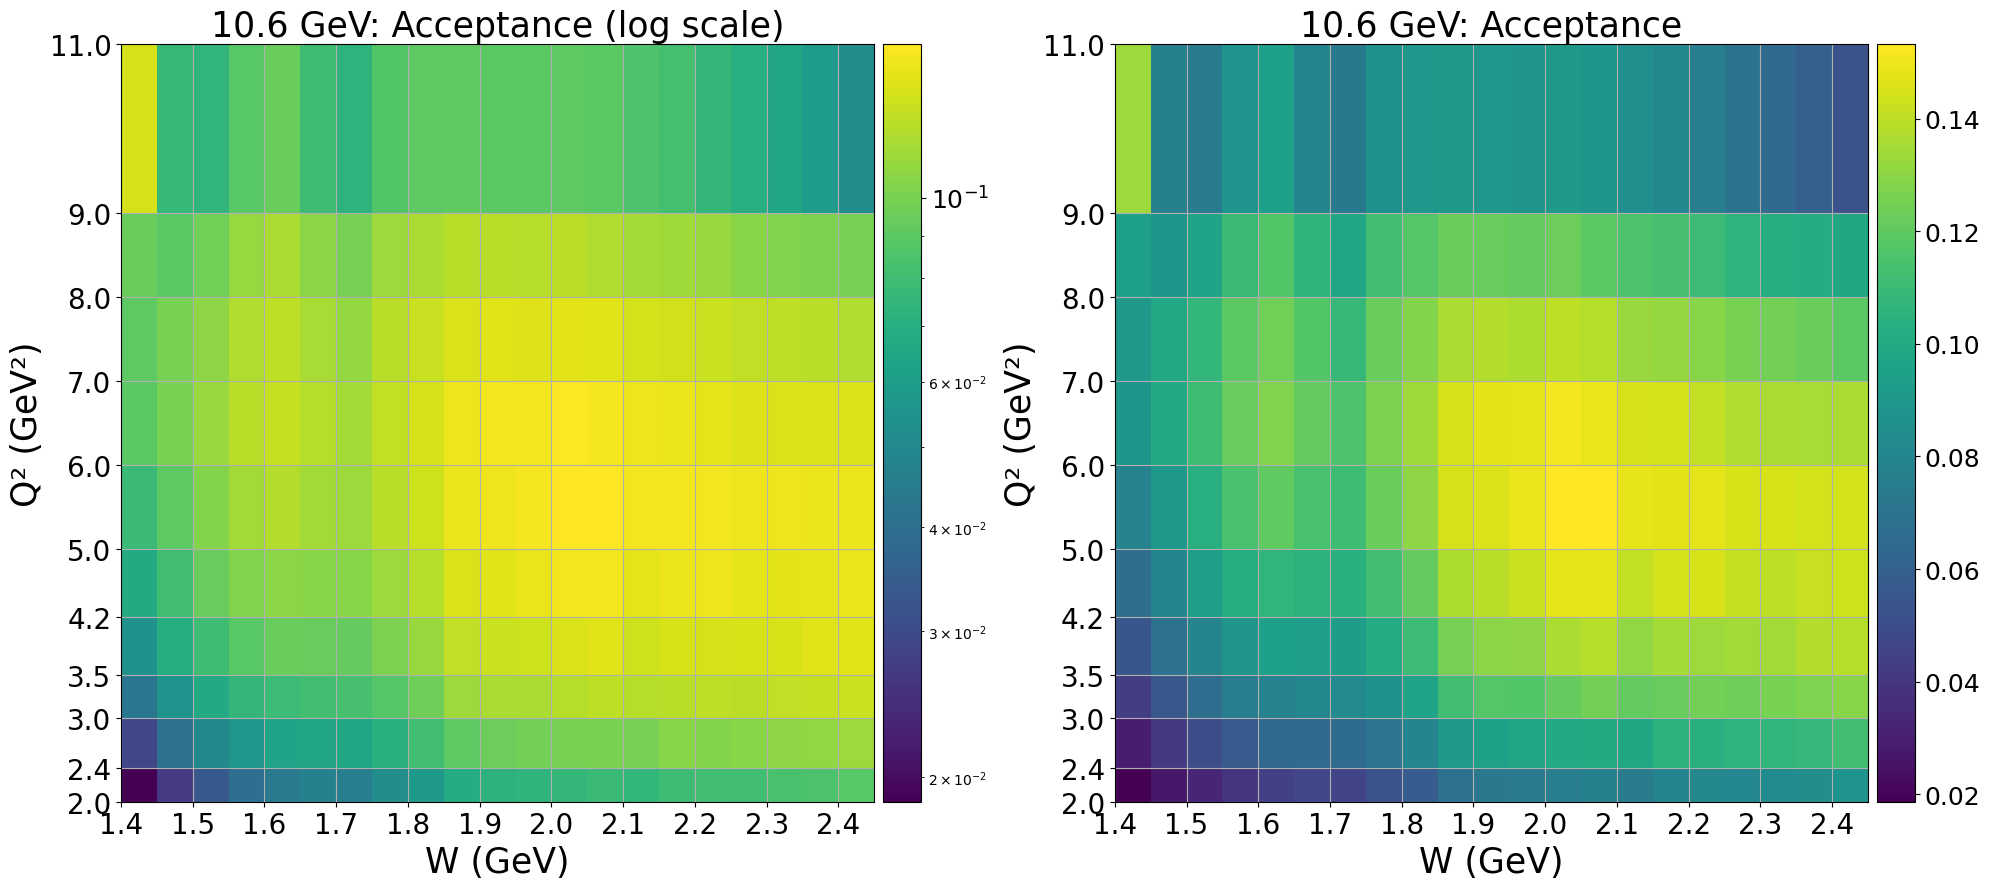

In [19]:
# Plot Acceptance: 10.6 GeV
def plot_acceptance(ax, data, log_norm=False, title=""):
    hist = ax.hist2d(
        data.w_val.to_numpy(),
        data.q2_val.to_numpy(),
        bins=[bin_x, bin_y],
        cmap='viridis',
        density=False,
        cmin=0,
        norm=mpl.colors.LogNorm() if log_norm else None,
        weights=data.acceptance,
    )

    # Labels / format
    ax.set_title(title, fontsize=25)
    ax.set_xlabel("W (GeV)", fontsize=25)
    ax.set_ylabel("Q² (GeV²)", fontsize=25)
    ax.tick_params(axis='both', which='both', labelsize=20)

    # Major ticks only (clean grid)
    ax.set_xticks(np.arange(1.4, 2.5, 0.1))
    ax.set_yticks(bin_y)
    ax.grid(which='both')

    # Colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.09)
    cbar = plt.colorbar(hist[3], cax=cax)
    cbar.ax.tick_params(labelsize=18)  # <--- adjust numeric labels

fig, axes = plt.subplots(1, 2, figsize=(20, 9))

plot_acceptance(axes[0], hist_10_6_gev_sim, log_norm=True, title="10.6 GeV: Acceptance (log scale)")
plot_acceptance(axes[1], hist_10_6_gev_sim, log_norm=False, title="10.6 GeV: Acceptance")

plt.tight_layout()
plt.show()


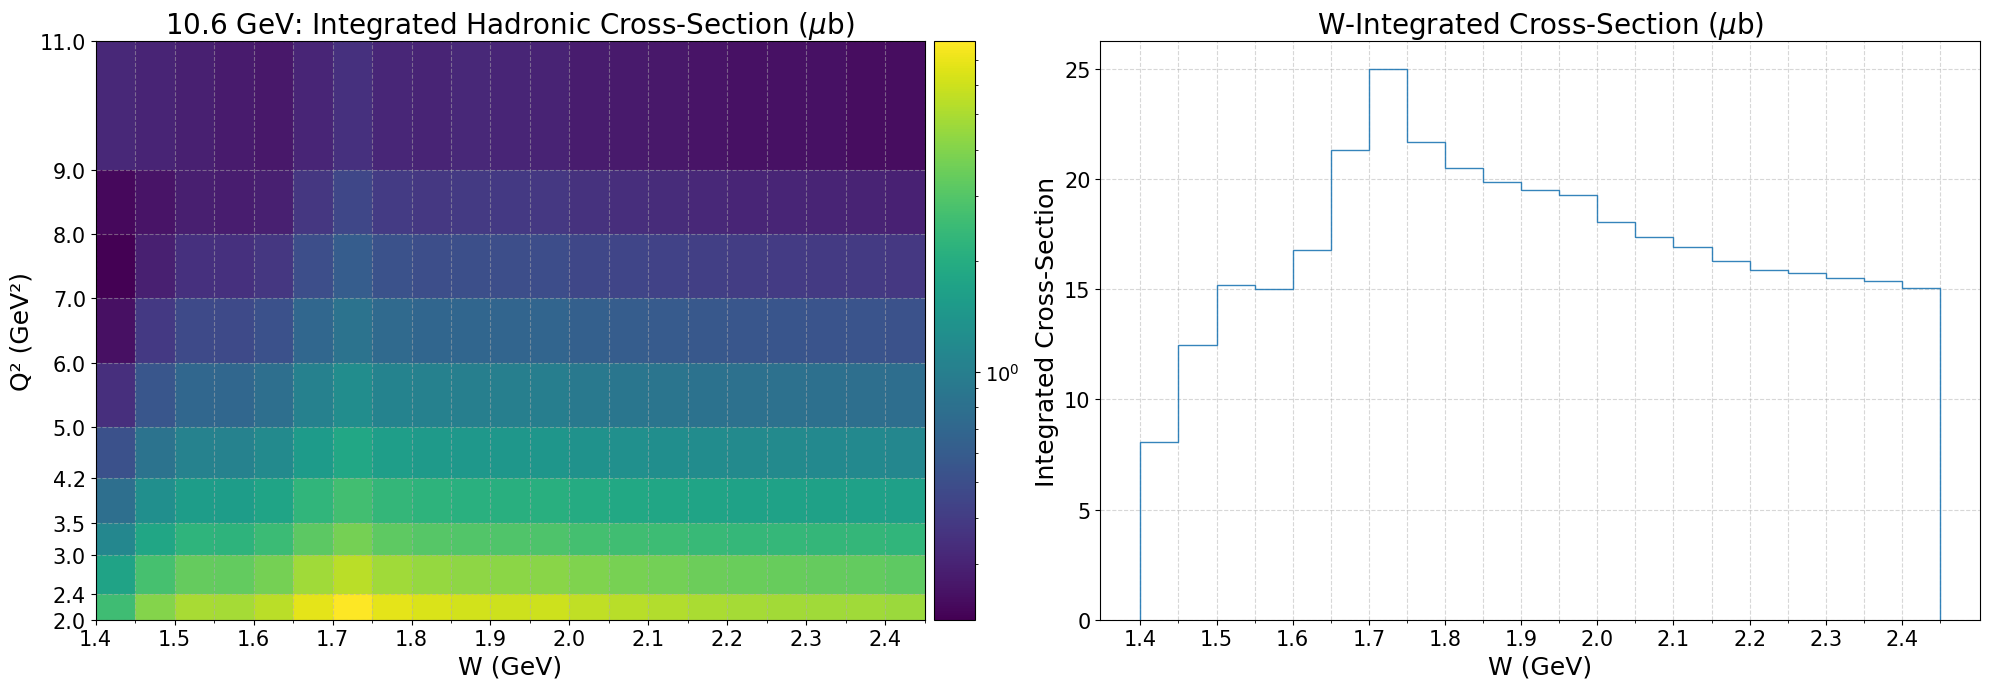

In [20]:
# Binning
major_xticks = np.arange(1.4, 2.5, 0.1)
minor_xticks = bin_x

fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# ----------- LEFT: 2D integrated cross section
ax = axes[0]
hist = ax.hist2d(hist_10_6_gev_sim.w_val.to_numpy(), hist_10_6_gev_sim.q2_val.to_numpy(), 
                 bins=[bin_x, bin_y], cmap='viridis', density=False, cmin=0, norm=mpl.colors.LogNorm(), weights=hist_10_6_gev_sim.cs_scaled)

ax.set_title('10.6 GeV: Integrated Hadronic Cross-Section ($\mu$b)', fontsize=20)
ax.set_xlabel('W (GeV)', fontsize=18)
ax.set_ylabel('Q² (GeV²)', fontsize=18)
ax.set_xticks(major_xticks)
ax.set_xticks(minor_xticks, minor=True)
ax.set_yticks(bin_y)
ax.grid(which='both', linestyle='--', alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=15)

# Add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.09)
cbar = plt.colorbar(hist[3], cax=cax)
cbar.ax.tick_params(labelsize=14)

# ----------- RIGHT: W-projected cross section
ax = axes[1]
ax.hist(hist_10_6_gev_sim.w_val.to_numpy(), range=(1.4, 2.5), bins=bin_x, weights=hist_10_6_gev_sim.cs_scaled, histtype='step', alpha=0.9)

ax.set_title('W-Integrated Cross-Section ($\mu$b)', fontsize=20)
ax.set_xlabel('W (GeV)', fontsize=18)
ax.set_ylabel('Integrated Cross-Section', fontsize=18)
ax.set_xticks(major_xticks)
ax.set_xticks(minor_xticks, minor=True)
ax.grid(which='both', linestyle='--', alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()
plt.show()


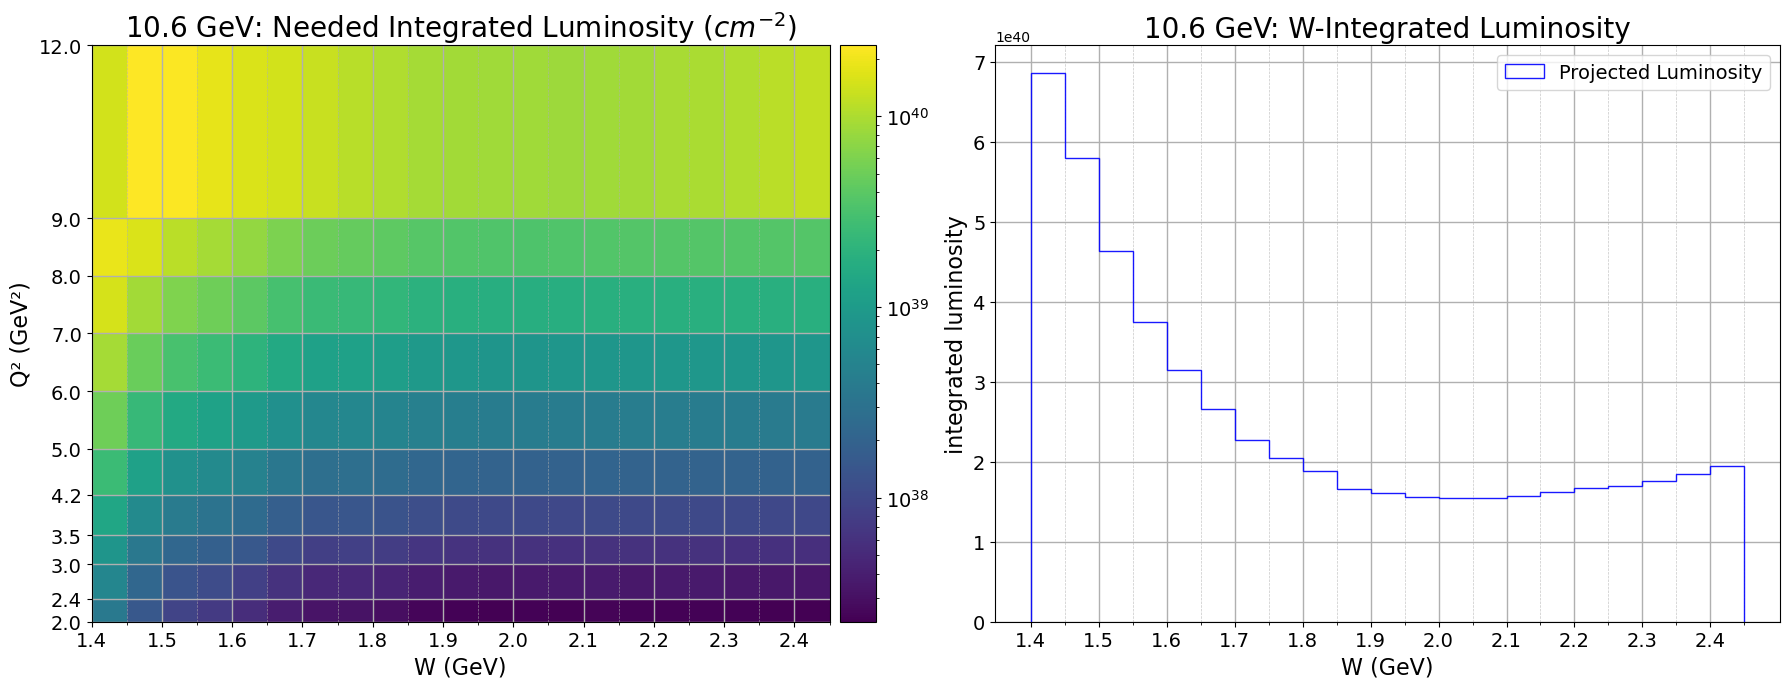

In [27]:
# Binning
major_xticks = np.arange(1.4, 2.5, 0.1)
minor_xticks = np.arange(1.4, 2.5, 0.05)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))  # left and right panels

# ----------- LEFT: 2D luminosity
ax = axes[0]
hist = ax.hist2d(hist_10_6_gev_sim.w_val.to_numpy(), hist_10_6_gev_sim.q2_val.to_numpy(),
    bins=[bin_x, bin_y], cmap='viridis', density=False, cmin=0, norm=mpl.colors.LogNorm(), weights=hist_10_6_gev_sim.lumi_elec)

ax.set_title('10.6 GeV: Needed Integrated Luminosity ($cm^{-2}$)', fontsize=20)
ax.set_xlabel('W (GeV)', fontsize=16)
ax.set_ylabel('Q² (GeV²)', fontsize=16)
ax.set_xticks(major_xticks)
ax.set_xticks(minor_xticks, minor=True)
ax.set_yticks(bin_y)
ax.tick_params(axis='both', which='major', labelsize=14)

ax.grid(which='major', linestyle='-', linewidth=1)
ax.grid(which='minor', linestyle='--', linewidth=0.5, alpha=0.7)

# Colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(hist[3], cax=cax)
cbar.ax.tick_params(labelsize=14)
# cbar.set_label('Integrated Luminosity ($cm^{-2}$)', fontsize=16)

# ----------- RIGHT: 1D luminosity (projection on W)
ax = axes[1]
ax.hist(hist_10_6_gev_sim.w_val.to_numpy(), bins=bin_x, range=(1.4, 2.5), weights=hist_10_6_gev_sim.lumi_elec, histtype='step', alpha=0.9, color='b', label='Projected Luminosity')

ax.set_title('10.6 GeV: W-Integrated Luminosity', fontsize=20)
ax.set_xlabel('W (GeV)', fontsize=16)
ax.set_ylabel('integrated luminosity', fontsize=16)
ax.set_xticks(major_xticks)
ax.set_xticks(minor_xticks, minor=True)
ax.grid(which='major', linestyle='-', linewidth=1)
ax.grid(which='minor', linestyle='--', linewidth=0.5, alpha=0.7)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14)

plt.tight_layout()
plt.show()


/var/folders/wd/z4b9mvxs2xb0v8hc2svy1l580000gp/T/ipykernel_78269/3169377253.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  bins=[bin_x, bin_y],cmap=plt.cm.get_cmap('viridis'), density=False,


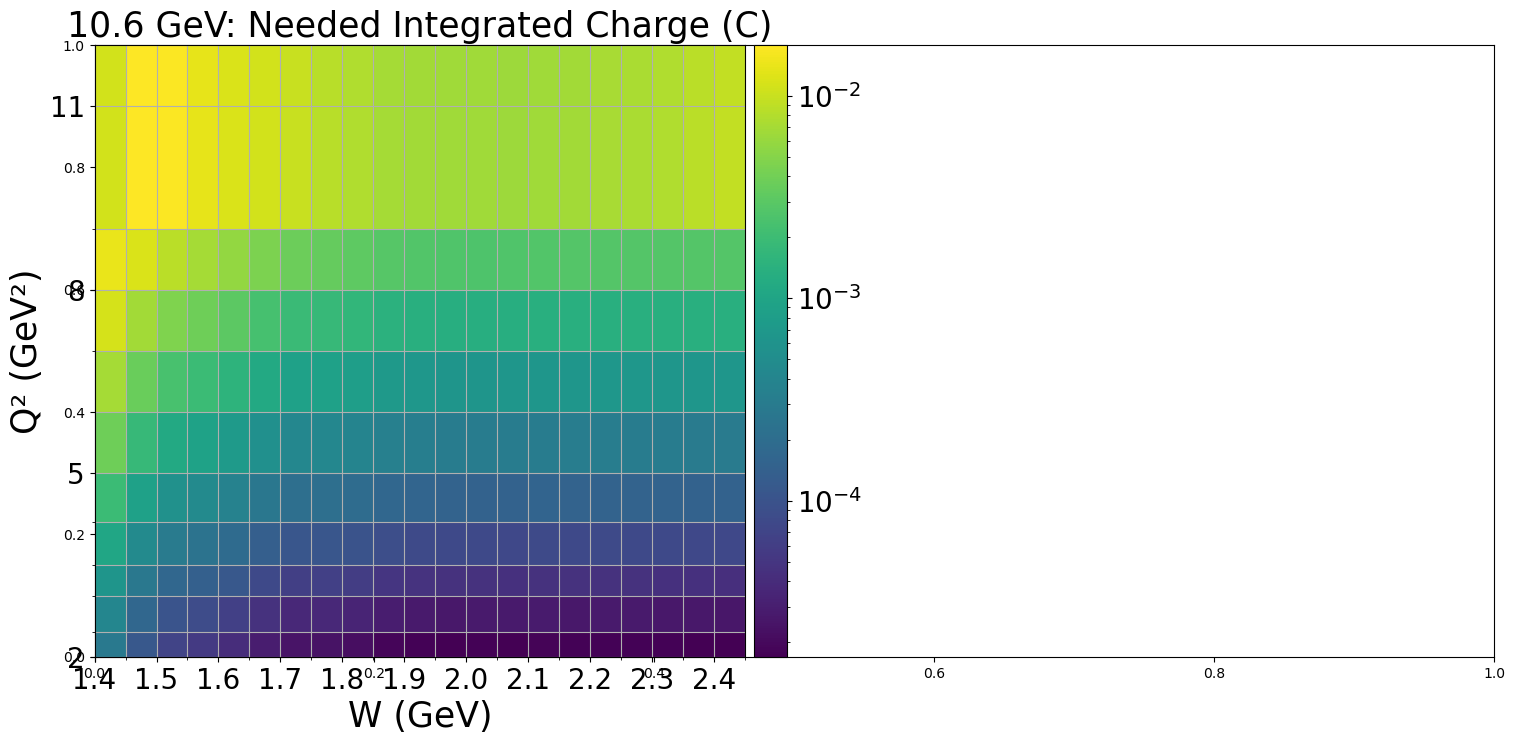

In [23]:
# find integrated charge needed: 10.6 GeV
from matplotlib.ticker import FormatStrFormatter
fig, ax = plt.subplots(figsize =(15,7))
ax=plt.subplot(1, 2, 1) # row 1, col 2 index 1

# Creating plot
bin_x=np.arange(1.4,2.5, 0.05)
bin_y=[2.0,2.4,3.0,3.5,4.2,5.0,6.0,7.0,8.0,9.0,12.0]
matplotlib.pyplot.hist2d(hist_10_6_gev_sim.w_val.to_numpy(),hist_10_6_gev_sim.q2_val.to_numpy(),
                         bins=[bin_x, bin_y],cmap=plt.cm.get_cmap('viridis'), density=False,
                         cmin =0,norm=mpl.colors.LogNorm(), weights=hist_10_6_gev_sim.q_elec)
  
# show plot
plt.tight_layout() 
plt.title('10.6 GeV: Needed Integrated Charge (C)',fontsize=25)
plt.xlabel('W (GeV)',fontsize=25)
plt.ylabel('Q\N{SUPERSCRIPT TWO} (GeV\N{SUPERSCRIPT TWO})',fontsize=25)

# Adding color bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.09)
plt.colorbar(cax=cax)
plt.tick_params(labelsize=20);
major_ticks = np.arange(1.4,2.5, 0.1)
minor_ticks = np.arange(1.4,2.5, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
major_ticks = [2.0,5.0,8.0,11.0]
minor_ticks = [2.0,2.4,3.0,3.5,4.2,5.0,6.0,7.0,8.0,9.0,12.0]
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')
ax.tick_params(axis='both', which='major', labelsize=20)

plt.show()

/var/folders/wd/z4b9mvxs2xb0v8hc2svy1l580000gp/T/ipykernel_77316/1060419760.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  bins=[bin_x, bin_y],cmap=plt.cm.get_cmap('viridis'), density=False,


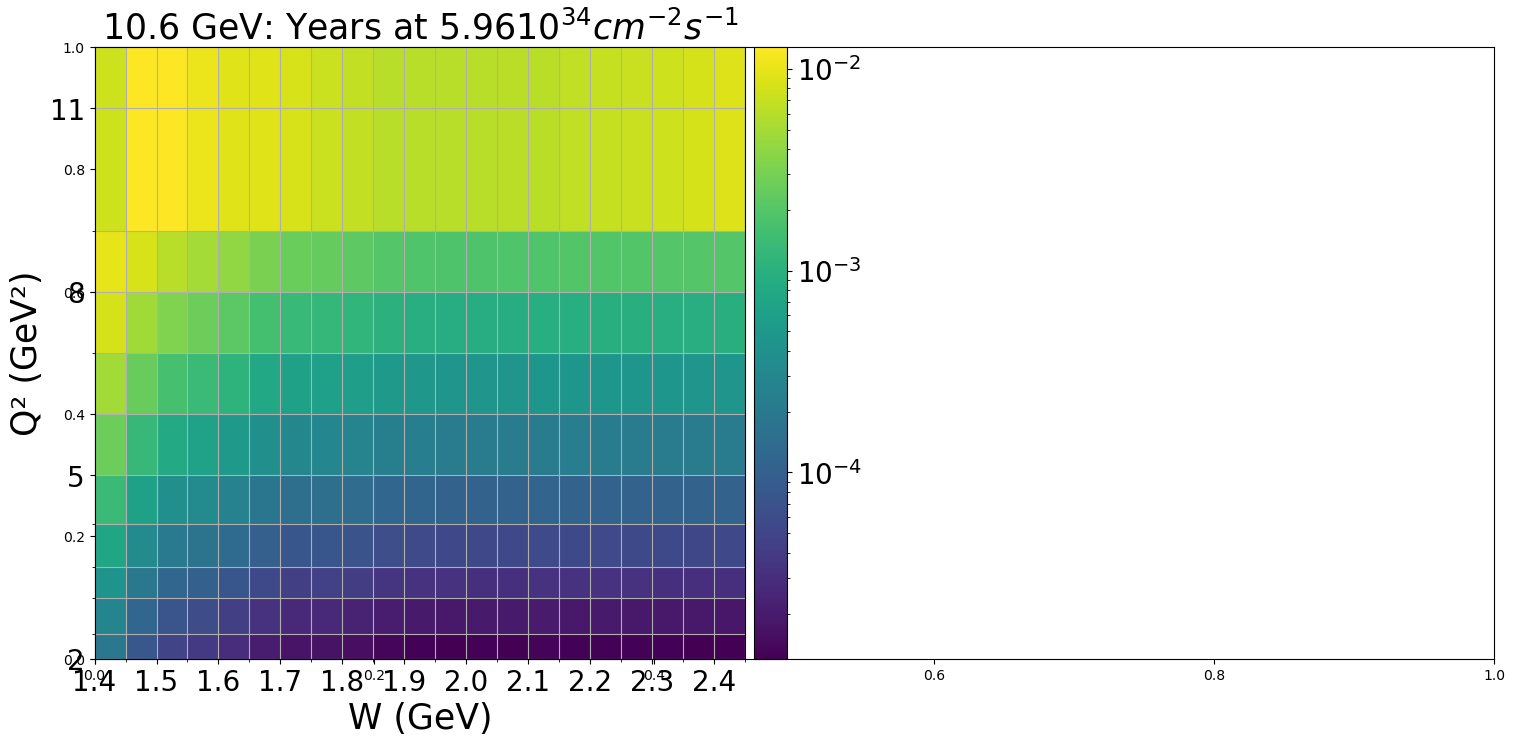

In [27]:
# find time needed in years: 10.6 GeV
from matplotlib.ticker import FormatStrFormatter
fig, ax = plt.subplots(figsize =(15,7))
ax=plt.subplot(1, 2, 1) # row 1, col 2 index 1

# Creating plot
bin_x=np.arange(1.4,2.5, 0.05)
minor_ticks = [2.0,2.4,3.0,3.5,4.2,5.0,6.0,7.0,8.0,9.0,12.0]
matplotlib.pyplot.hist2d(hist_10_6_gev_sim.w_val.to_numpy(),hist_10_6_gev_sim.q2_val.to_numpy(),
                         bins=[bin_x, bin_y],cmap=plt.cm.get_cmap('viridis'), density=False,
                         cmin =0,norm=mpl.colors.LogNorm(), weights=hist_10_6_gev_sim.no_year_45nA)
  
# show plot
plt.tight_layout() 
plt.title('10.6 GeV: Years at $5.96 10^{34} cm^{-2} s^{-1}$',fontsize=25)
plt.xlabel('W (GeV)',fontsize=25)
plt.ylabel('Q\N{SUPERSCRIPT TWO} (GeV\N{SUPERSCRIPT TWO})',fontsize=25)

# Adding color bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.09)
plt.colorbar(cax=cax)
plt.tick_params(labelsize=20);
major_ticks = np.arange(1.4,2.5, 0.1)
minor_ticks = np.arange(1.4,2.5, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
major_ticks = [2.0,5.0,8.0,11.0]
minor_ticks = [2.0,2.4,3.0,3.5,4.2,5.0,6.0,7.0,8.0,9.0,12.0]
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')
ax.tick_params(axis='both', which='major', labelsize=20)

plt.show()

/var/folders/wd/z4b9mvxs2xb0v8hc2svy1l580000gp/T/ipykernel_77316/1982230185.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  bins=[bin_x, bin_y],cmap=plt.cm.get_cmap('viridis'), density=False,


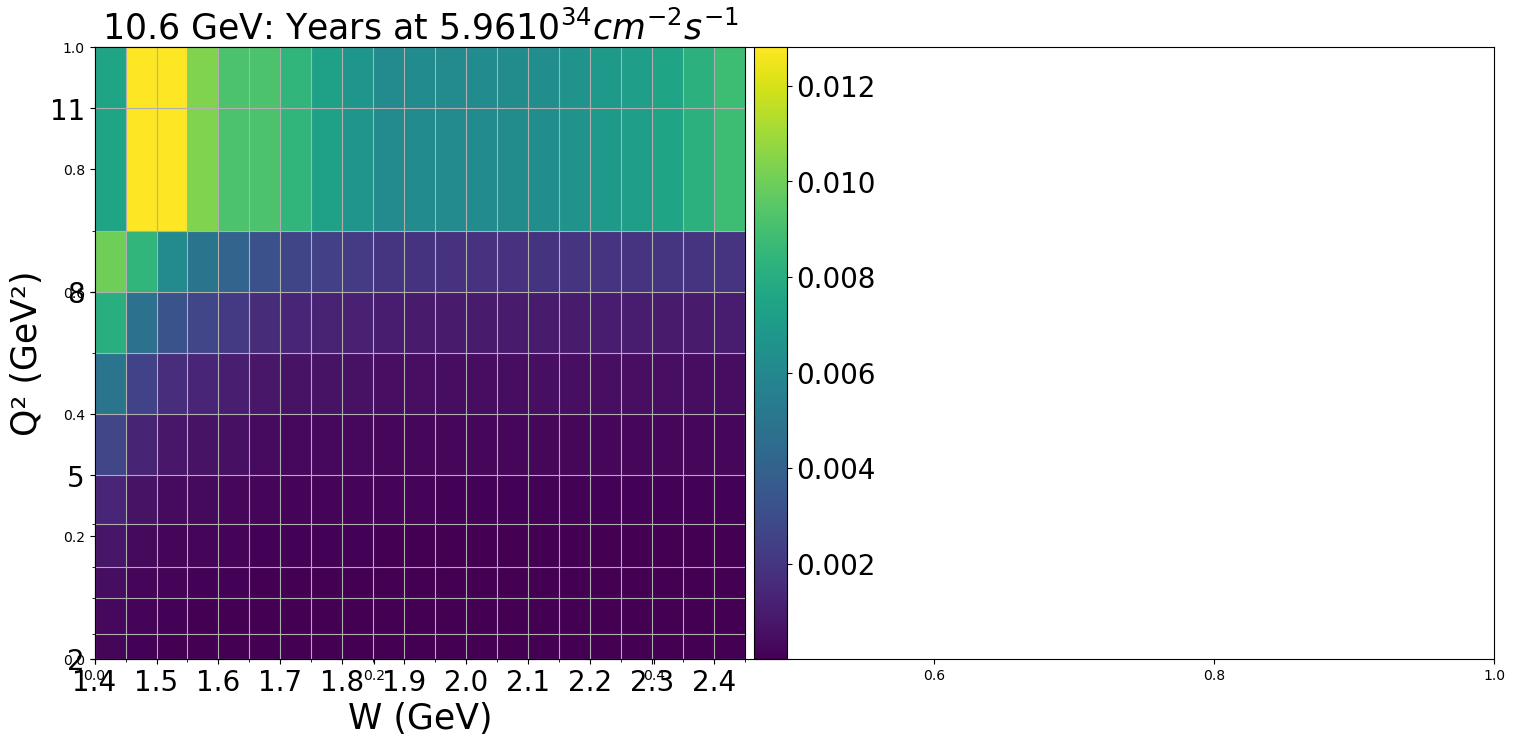

In [28]:
# find time needed in years: 10.6 GeV
from matplotlib.ticker import FormatStrFormatter
fig, ax = plt.subplots(figsize =(15,7))
ax=plt.subplot(1, 2, 1) # row 1, col 2 index 1

# Creating plot
bin_x=np.arange(1.4,2.5, 0.05)
bin_y=[2.0,2.4,3.0,3.5,4.2,5.0,6.0,7.0,8.0,9.0,12.0]
matplotlib.pyplot.hist2d(hist_10_6_gev_sim.w_val.to_numpy(),hist_10_6_gev_sim.q2_val.to_numpy(),
                         bins=[bin_x, bin_y],cmap=plt.cm.get_cmap('viridis'), density=False,
                         cmin =0, weights=hist_10_6_gev_sim.no_year_45nA)
  
# show plot
plt.tight_layout() 
plt.title('10.6 GeV: Years at $5.96 10^{34} cm^{-2} s^{-1}$',fontsize=25)
plt.xlabel('W (GeV)',fontsize=25)
plt.ylabel('Q\N{SUPERSCRIPT TWO} (GeV\N{SUPERSCRIPT TWO})',fontsize=25)

# Adding color bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.09)
plt.colorbar(cax=cax)
plt.tick_params(labelsize=20);
major_ticks = np.arange(1.4,2.5, 0.1)
minor_ticks = np.arange(1.4,2.5, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
major_ticks = [2.0,5.0,8.0,11.0]
minor_ticks = [2.0,2.4,3.0,3.5,4.2,5.0,6.0,7.0,8.0,9.0,12.0]
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')
ax.tick_params(axis='both', which='major', labelsize=20)

plt.show()